###Cropping
Turned out not to be all that easy. Here is my solution, using mostly numpy.
skimage is very slow. We've got 31K images in the training set alone, piping it through that is gonna take a while. Divide & conquer perhaps?

I have checked in an acual Python script together with this. Also, to run it - modify the root path.

The main problem is that <em><b>the black is NOT always black</em></b> in the backgrownd. This necessitates using contour finding. Otherwise I'd just use numpy [numpy.nonzero](http://docs.scipy.org/doc/numpy/reference/generated/numpy.nonzero.html) and be done with it.

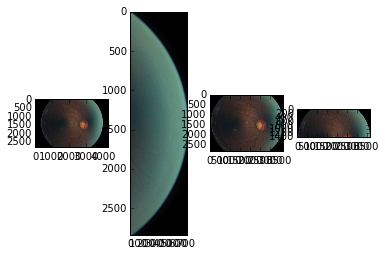

In [10]:
# %load edges.py
from skimage import io
from os import path
from matplotlib import pyplot as plt
from skimage.feature import canny
import numpy as np
import cv2
from skimage.color.colorconv import rgb2gray
from autocrop import crop_manual

def do_cropping(eye, edge):
    row_dim, col_dim = np.nonzero(edge)

    x_top, y_left = row_dim[0], np.min(col_dim)
    x_bottom, y_right = row_dim[-1], np.max(col_dim)

    return eye[x_top : x_bottom, y_left : y_right, :]

def crop_cv(eye):
    red_eye = eye[:, :, 0]

    # compute the Otsu th
    thresh_value, _ = cv2.threshold(red_eye, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    upper, lower = thresh_value, thresh_value / 2
    edges = cv2.Canny(eye, upper, lower)
    return do_cropping(eye, edges)

def crop_sk(eye):
    red_eye = rgb2gray(eye)

    edges = canny(red_eye, sigma=3)
    return do_cropping(eye, edges)

root = path.normpath('c:/kaggle/retina/train')
an_eye = path.join(root, '20677_left.jpeg')
eye = io.imread(an_eye)
#eye_cv = cv2.imread(an_eye, cv2.IMREAD_GRAYSCALE)


# get just one channel
cropped = crop_sk(eye)
cropped1 = crop_cv(eye)
cropped2 = crop_manual(eye)

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
ax1.imshow(eye)
ax2.imshow(cropped)
ax3.imshow(cropped1)
ax4.imshow(cropped2)
plt.show()

In [11]:
%timeit crop_sk(eye)
%timeit crop_cv(eye)
%timeit crop_manual(eye)

1 loops, best of 3: 7.46 s per loop
1 loops, best of 3: 408 ms per loop
1 loops, best of 3: 195 ms per loop


The "auto" (or manual) method for cropping is the fastest. But we need a better methodology for detecting edges.